# Collecting data from social media

We are going to be collecting posts from Reddit to analyze with sentiment analysis. We will be first collecting data using the Python wrapper for Reddit (PRAW) which uses the Reddit API, then storing the data into a sqlite3 database file. First, make sure you have praw installed: `conda install -c conda-forge praw -y`.

Also make sure you have your Reddit API credentials ready to go (follow the instructions in the Reddit_API_key_instructions.docx file first then ask your instructor if you need more help).

In [2]:
import praw
import pandas as pd

import credentials

The `import credentials` line imports the file `credentials.py` from the same directory as this Jupyter Notebook. Fill in the variables in that file with your API credentials before loading it. This is slightly more secure than putting our credentials directly in the notebook because we could ignore the credentials.py file with our .gitignore file if we were uploading this to GitHub.

Next, we initialize our reddit connection with our credentials.

In [3]:
reddit = praw.Reddit(client_id=credentials.client_id,
                     client_secret=credentials.client_secret,
                     user_agent=credentials.user_agent)

Version 7.0.0 of praw is outdated. Version 7.4.0 was released Friday July 30, 2021.


Now we can select a subreddit of interest. We can use 'all' for all subreddits, but we'll try the Colorado subreddit first. We can select posts by 'top', 'hot', or other viewing options that you see in the web browser too. Then we can set an option for the time frame for some filters such as 'top', and we can use the time filters of all, day, hour, month, week, year (default: all). The PRAW documentation is a little difficult to navigate to find this information, but it's on this page: https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html#praw.models.Subreddit.search

In [61]:
mc_subreddit = reddit.subreddit('MedievalCats').traffic(limit=10)

This returns a generator object, which is like a list, but we only get the elements when we ask for them, and only one time. So we can loop through the once:

In [5]:
for post in mc_subreddit:
    print(post.title, post.score)

When you're a kid and wake up to your Parents having a Big Adult Party in the next room. 241
The face you make when your owner tells her date over supper "I'm a really good catch, you know!" 44
(mouth breathing intensifies) 19
Happy Humpday Mood Check - Which Cat are You Today? 728
I saw this handsome fella in NYC today 577
Leo: "This person tastes really salty." 🧂 Larry: "Probably a Redditor." 91
Panther says Good Morning & he is happy to see you. 994
No thank you 0
St. Jerome and The Microdosing Lion 786
Jackson loved his new job as a Rocket Scientist 38


And now if we try to access the elements, they are gone (because we accessed them):

In [7]:
list(mc_subreddit)

[]

This is mainly to conserve memory for very large objects, but can also be used to stream data or other things. If we convert it to a list right away, like this:

`co_subreddit = reddit.subreddit('colorado').top('month', limit=10)`

Then the data stays in the list (the `co_subreddit` object).

We still have our last post item from the list, and we can see what properties are accessible by typing `post.` and pressing tab.

In [8]:
post.thumbnail

'https://b.thumbs.redditmedia.com/d9T4cd9zf-LH1ktsoBc-9Y-HxsRrpoS12mVgr7BYpOw.jpg'

In [9]:
post.score

34

In [10]:
post.title

'Jackson loved his new job as a Rocket Scientist'

In [11]:
post.permalink

'/r/MedievalCats/comments/q1tuuz/jackson_loved_his_new_job_as_a_rocket_scientist/'

We can save some data of interest, like the title, author, permalink (in case we want to go and see the post), number of comments, and score (something like the upvotes minus downvotes). We will save these in a format that we can easily drop into a pandas DataFrame, which is a dictionary of lists.

In [12]:
fields = {'title', 'link', 'author', 'n_comments', 'score', 'text'}
reddit_data = {k: [] for k in fields}


mc_subreddit = reddit.subreddit('MedievalCats').hot(limit=None)

for post in list(mc_subreddit):
    reddit_data['title'].append(post.title)
    reddit_data['link'].append(post.permalink)
    if post.author is None:
        reddit_data['author'].append('')
    else:
        reddit_data['author'].append(post.author.name)
    
    reddit_data['n_comments'].append(post.num_comments)
    reddit_data['score'].append(post.score)
    reddit_data['text'].append(post.selftext)

By the way, you probably want to set the `limit=None` argument once you have your code ready in your assignment this collects the maximum number of posts avialable (up to the API limits).

In [13]:
mc_df = pd.DataFrame(reddit_data)

In [14]:
mc_df

,title,link,author,n_comments,score,text
0,When you're a kid and wake up to your Parents ...,/r/MedievalCats/comments/q35yt1/when_youre_a_k...,igneousink,3,245,
1,The face you make when your owner tells her da...,/r/MedievalCats/comments/q36013/the_face_you_m...,igneousink,0,42,
2,(mouth breathing intensifies),/r/MedievalCats/comments/q35xhm/mouth_breathin...,igneousink,0,19,
3,Happy Humpday Mood Check - Which Cat are You T...,/r/MedievalCats/comments/q2gy0t/happy_humpday_...,igneousink,117,727,
4,I saw this handsome fella in NYC today,/r/MedievalCats/comments/q2bf0j/i_saw_this_han...,pandacat3,11,579,
...,...,...,...,...,...,...
975,I painted the “Oh hai thar. I touch your foods...,/r/MedievalCats/comments/m14te6/i_painted_the_...,the-limbic-system,29,1199,
976,Igneousink had a modern cat that wanted to be ...,/r/MedievalCats/comments/m1mvhv/igneousink_had...,amnesiacprotagonists,3,64,
977,When the Ergot tastes like Schnozzberries,/r/MedievalCats/comments/m1tsxn/when_the_ergot...,igneousink,1,17,
978,am circle,/r/MedievalCats/comments/m1h4yc/am_circle/,igneousink,2,70,


# Save data to sqlite

Now that we have some data collected, we can save it to a database. Sqlite3 is built-in with Python, and saves the data to a file on our hard drive. It's easy to use and set up, although it has limitations. We can save our data like so:

In [16]:
import sqlite3

con = sqlite3.connect("co_reddit.sqlite")
mc_df.to_sql('posts', con, if_exists='replace', index=False)

We can easily create our DB file by connecting to it (make sure the path exists if you provide a directory/folder like 'data' here). Then we use the to_sql command, giving it a table name, our connection, and a few other arguments. The if_exists can be replace, append, or fail, which do what they say (see the [docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html) for more).

Once our data is saved, we can check that we can load it back:

In [17]:
mc_df_check = pd.read_sql_query('SELECT * FROM posts;', con)
# it's best to close the connection when finished
con.close()
mc_df_check

,title,link,author,n_comments,score,text
0,When you're a kid and wake up to your Parents ...,/r/MedievalCats/comments/q35yt1/when_youre_a_k...,igneousink,3,245,
1,The face you make when your owner tells her da...,/r/MedievalCats/comments/q36013/the_face_you_m...,igneousink,0,42,
2,(mouth breathing intensifies),/r/MedievalCats/comments/q35xhm/mouth_breathin...,igneousink,0,19,
3,Happy Humpday Mood Check - Which Cat are You T...,/r/MedievalCats/comments/q2gy0t/happy_humpday_...,igneousink,117,727,
4,I saw this handsome fella in NYC today,/r/MedievalCats/comments/q2bf0j/i_saw_this_han...,pandacat3,11,579,
...,...,...,...,...,...,...
975,I painted the “Oh hai thar. I touch your foods...,/r/MedievalCats/comments/m14te6/i_painted_the_...,the-limbic-system,29,1199,
976,Igneousink had a modern cat that wanted to be ...,/r/MedievalCats/comments/m1mvhv/igneousink_had...,amnesiacprotagonists,3,64,
977,When the Ergot tastes like Schnozzberries,/r/MedievalCats/comments/m1tsxn/when_the_ergot...,igneousink,1,17,
978,am circle,/r/MedievalCats/comments/m1h4yc/am_circle/,igneousink,2,70,


# Basic EDA on our data

Our data we've collected has text (the title), authors (a categorical variable) and the score and number of comments (numeric). We can make a few plots with these:

- word count plots
- a bar plot of the unique authors
- numeric EDA plots of the number of comments and score, such as histograms, box plots, etc

Let's start with what we already know, which is everything but the word count plots.

<AxesSubplot:ylabel='Frequency'>

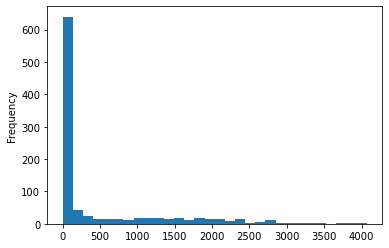

In [18]:
mc_df['score'].plot.hist(bins=30)

It looks like the distribution is highly asymmetric, with many posts having a score near 0 (probably because they are new) and a few posts with a very high score. We can look at the highest-scored posts:

In [21]:
mc_df[mc_df['score'] > 4000]

,title,link,author,n_comments,score,text
751,Cats still haven't changed,/r/MedievalCats/comments/mrnvn2/cats_still_hav...,TrilliumLady37,33,4072,


By printing out the links like this, we can visit them by putting www.reddit.com in from of them.

In [22]:
mc_df[mc_df['score'] > 4000]['link'].to_list()

['/r/MedievalCats/comments/mrnvn2/cats_still_havent_changed/']

<AxesSubplot:>

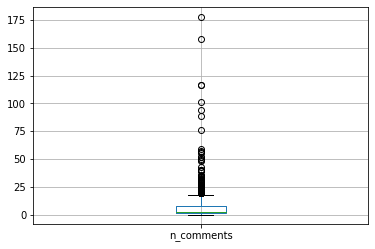

In [25]:
import matplotlib.pyplot as plt
mc_df.boxplot('n_comments')

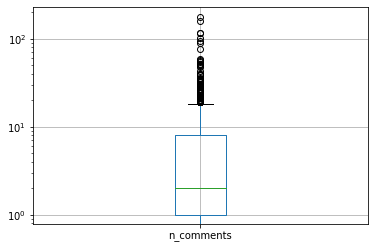

In [26]:
import matplotlib.pyplot as plt
mc_df.boxplot('n_comments')
plt.yscale('log')

Again, we see some large outliers for number of comments. A more modern version of the boxplot is the letter-value plot, called a boxenplot in Seaborn (https://seaborn.pydata.org/generated/seaborn.boxenplot.html).

<AxesSubplot:xlabel='score', ylabel='n_comments'>

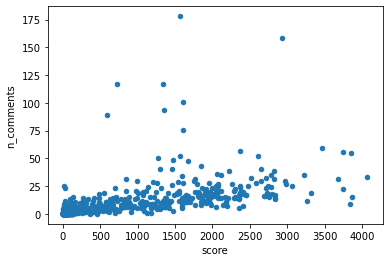

In [28]:
mc_df.plot.scatter(x='score', y='n_comments')

We can see a roughly positive relationship between the score and number of comments, as we might expect.

Next, let's look at the frequency counts of users who post things:

<AxesSubplot:>

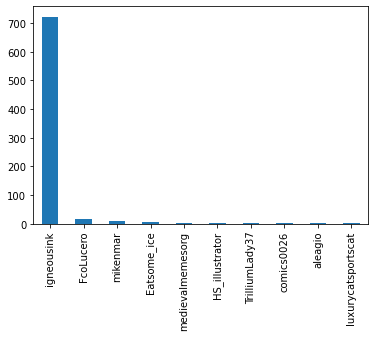

In [29]:
mc_df['author'].value_counts()[:10].plot.bar()

We can then see what these top authors are posting with filtering:

In [31]:
mc_df[mc_df['author'] == 'igneousink']

,title,link,author,n_comments,score,text
0,When you're a kid and wake up to your Parents ...,/r/MedievalCats/comments/q35yt1/when_youre_a_k...,igneousink,3,245,
1,The face you make when your owner tells her da...,/r/MedievalCats/comments/q36013/the_face_you_m...,igneousink,0,42,
2,(mouth breathing intensifies),/r/MedievalCats/comments/q35xhm/mouth_breathin...,igneousink,0,19,
3,Happy Humpday Mood Check - Which Cat are You T...,/r/MedievalCats/comments/q2gy0t/happy_humpday_...,igneousink,117,727,
5,"Leo: ""This person tastes really salty."" 🧂 Larr...",/r/MedievalCats/comments/q2h6q9/leo_this_perso...,igneousink,0,91,
...,...,...,...,...,...,...
972,"""Yah, OK, I'll join your Business Venture. Are...",/r/MedievalCats/comments/m2c6lx/yah_ok_ill_joi...,igneousink,1,36,
973,When you really want to be on Medieval Cats bu...,/r/MedievalCats/comments/m1h5yu/when_you_reall...,igneousink,18,2748,
974,Medieval life was hard.,/r/MedievalCats/comments/m1yh0q/medieval_life_...,igneousink,1,30,
977,When the Ergot tastes like Schnozzberries,/r/MedievalCats/comments/m1tsxn/when_the_ergot...,igneousink,1,17,


It looks like this person is posting some controversial things!

Next, we can look at the text with some EDA. One simple thing to look at for text is word and n-gram counts. n-grams are groups of words of length n, like 2-grams (bigrams), 3-grams (bigrams), etc. One easy way to visualize these as bar plots is with the NLTK package, which we must install first: `conda install -c conda-forge nltk -y`.

Word counts are very similar to the value counts plot above.

In [32]:
!conda install -c conda-forge nltk -y

Solving environment: ...working... done

# All requested packages already installed.



Here, we use a few sting methods - join and split. `join()` joins together a list of strings with a character. In this case, we are joining together all the titles with a single space. `split()` splits text on a character we provide as an argument. By default, it splits on any whitespaces (spaces, newlines, tabs, etc).

In [33]:
import nltk

fd = nltk.FreqDist(' '.join(mc_df['title']).split())

fd.most_common(20)

[('the', 399),
 ('.', 260),
 ('a', 257),
 ('you', 212),
 ('to', 210),
 ('of', 148),
 ('I', 143),
 ('in', 103),
 ('and', 87),
 ('The', 80),
 ('Medieval', 77),
 ('this', 76),
 ('your', 74),
 ('Cat', 68),
 ('is', 68),
 ('was', 59),
 ('my', 57),
 ('for', 55),
 ('cat', 54),
 ('&', 52)]

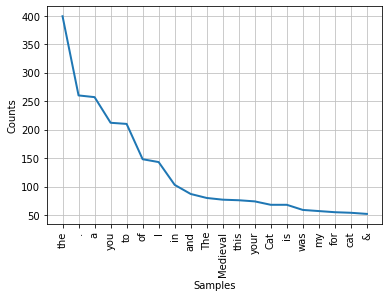

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [35]:
fd.plot(20)

We can see many of the top words are common words like 'the' and 'a' that don't tell us much. We can get rid of these, but also have some more preprocessing to do. A few things we can do to make our text analysis slightly better is to lowercase all words (so things like 'Colorado' and 'colorado' get counted as the same word) and remove stopwords. Stopwords are common words that don't give us much meaning. NLTK, SpaCy, and scikit-learn all have lists of stopwords. We can use NLTK's list, but need to download them first:

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SCULLY\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

Then we can import them and look at the stopwords:

In [45]:
from nltk.corpus import stopwords

stops = stopwords.words('english')
stops = set(stops) | set(['"', '.', '&', '-', '"i', "i'm", "medieval", "cats", "cat,", "cat"])

Notice that they are lowercase and include punctuation. We can remove our stopwords from the text like so. We are lowercasing the full string of titles with the `lower()` built-in string method.

In [46]:
words = ' '.join(mc_df['title']).lower().split()
cleaned_words = [w for w in words if w not in set(stops)]

In [47]:
cleaned_fd = nltk.FreqDist(cleaned_words)
cleaned_fd.most_common(20)

[('get', 48),
 ('like', 46),
 ('said', 38),
 ('lion', 29),
 ('face', 27),
 ('make', 24),
 ('know', 22),
 ('one', 22),
 ('good', 20),
 ('probably', 20),
 ('going', 19),
 ('little', 19),
 ('thought', 19),
 ('got', 19),
 ('really', 18),
 ('never', 17),
 ('see', 16),
 ('think', 16),
 ('time', 16),
 ('"i\'m', 15)]

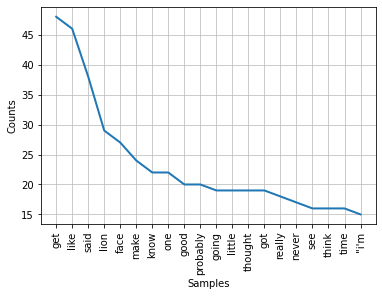

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [48]:
cleaned_fd.plot(20)

We can see now our analysis is more meaningful. We could also remove punctuation and other common words like 'colorado' and 'co' for a better analysis. More advanced steps include stemming or lemmatizing, which condenses words like 'sunset' and 'sunsets' to 'sunset' (removes plural endings, etc). To remove custom stopwords, we can add the new words to our stopwords. Here are two methods using a list and a set:

```python
stops = stops + ['colorado']
stops = set(stops) | set(['colorado', 'co'])
```

# Optional Advanced Section

Contents:
- Creating a SQLite table from scratch and other SQL commands
- sqlalchemy
- Getting comments
- Saving timestamps
- Scraping more data

## SQL commands

To create a sqlite table from scratch, we need to use SQL commands like `CREATE TABLE`. Usually pandas will correctly infer the type when creating a table, but we may need to force it in certain instances.  SQL syntax usually has a main command and then other subcommands or options after it. Most of the major SQL commands are [here](https://www.w3schools.com/sql/sql_syntax.asp), although the most common command is `SELECT` to get data. If we want to get only a certain column of data, we can do so like:

In [49]:
con = sqlite3.connect('co_reddit.sqlite')
test_df = pd.read_sql_query('SELECT title, n_comments FROM posts;', con)
con.close()
test_df

,title,n_comments
0,When you're a kid and wake up to your Parents ...,3
1,The face you make when your owner tells her da...,0
2,(mouth breathing intensifies),0
3,Happy Humpday Mood Check - Which Cat are You T...,117
4,I saw this handsome fella in NYC today,11
...,...,...
975,I painted the “Oh hai thar. I touch your foods...,29
976,Igneousink had a modern cat that wanted to be ...,3
977,When the Ergot tastes like Schnozzberries,1
978,am circle,2


There are many more available subcommands for SELECT, such as WHERE (for filtering, like with dataframes), GROUP BY (similar to dataframes again) and more. The documentation for different SQL variants explains all the available commands and subcommands, like [this](https://dev.mysql.com/doc/refman/8.0/en/select.html) for MySQL.

## SQLAlchemy

Although sqlite3 works for sqlite, to use other SQL databases we can use the sqlalchemy package in Python. It's more complex but much more flexible. The [docs](https://www.sqlalchemy.org/) are decent for the package.

## Getting comments and other data

We can get MUCH more data by getting comments from subreddit posts. There is some more information on this in the [docs](https://praw.readthedocs.io/en/latest/tutorials/comments.html), but we can get comments like this for our current posts (note this takes a while to run):

In [50]:
reddit_posts_data = {'title': [],
                    'link': [],
                    'author': [],
                    'n_comments': [],
                    'score': [],
                    'text': [],
                    'id': []}

reddit_comments_data = {'author': [],
                        'score': [],
                        'text': [],
                        'post_id': []}


mc_subreddit = reddit.subreddit('medievalcats').new(limit=None)

for post in list(mc_subreddit):
    reddit_posts_data['title'].append(post.title)
    reddit_posts_data['link'].append(post.permalink)
    if post.author is None:
        reddit_posts_data['author'].append(None)
    else:
        reddit_posts_data['author'].append(post.author.name)
    reddit_posts_data['n_comments'].append(post.num_comments)
    reddit_posts_data['score'].append(post.score)
    reddit_posts_data['text'].append(post.selftext)
    reddit_posts_data['id'].append(post.id)

    post.comments.replace_more(limit=None)
    for comment in post.comments:
        if comment.author is None:
            reddit_comments_data['author'].append('')
        else:
            reddit_comments_data['author'].append(comment.author.name)
        reddit_comments_data['score'].append(comment.score)
        reddit_comments_data['text'].append(comment.body)
        reddit_comments_data['post_id'].append(post.id)

post_df = pd.DataFrame(reddit_posts_data)
comment_df = pd.DataFrame(reddit_comments_data)

con = sqlite3.connect('co_reddit.sqlite')
post_df.to_sql('posts', con, if_exists='replace')
comment_df.to_sql('comments', con, if_exists='replace')
con.close()

In [51]:
comment_df

,author,score,text,post_id
0,Mechanical_Indian,5,I like the picture. I don't see the relation t...,q35yt1
1,malcome-the-spedbump,36,Is 1 ripping a hole in space time? Or just loo...,q2gy0t
2,bubbletrollbutt,13,12 all the way,q2gy0t
3,igneousink,11,I'm definitely a 9. Being up in a tree away f...,q2gy0t
4,larit,10,"7, Me and the lads found you a nice rat in the...",q2gy0t
...,...,...,...,...
3679,TrilliumLady37,3,More than one of the Oxburgh pieces is politic...,m7o05u
3680,ellieD,2,Nice eyebrows!\n\n:),m7o05u
3681,Ghukly,1,Looks like something I would make when rethink...,m7o05u
3682,igneousink,2,I LOVE it kittenbeans66!! \n\ndid you use a m...,m7ijs5


In [52]:
comment_df.shape

(3684, 4)

In [53]:
post_df.shape

(927, 7)

The comments can veer off into tangents sometimes, so may not always be helpful. But that's where much of the text content can sometimes be, and it's more 

The replace_more method replaces all the 'more comments' links with the actual comments (if limit=None, otherwise gets rid of them if limit=0). This can take a while to run if there are lots of comments. The comment object that we use in the inner loop then stores info on the comment, such as the author, score, text, and so on.

To store this data, you can use a separate table for the comments and one for the posts. If each table has a 'postID' column or something like it (with the `post.id` so we can match the comments with the original posts if we want).

You can also see what things are available for a comment object either in the PRAW docs or by looking at the object directly (e.g. by typing 'comment.' the pressing tab).


Note: you can use the `tqdm` package to wrap the loops to see a progress bar (to estimate time remaining), like this:
```python
from tqdm import tqdm

for post in tqdm(list(co_subreddit)):
    ...
```    

We can also get other data like images, time the post or comment was created at (the created_utc property of posts and comments, which is the time since the epoch in the UTC timezone) and more. If we are saving images (or even videos), we can download them and save them in the database as a BLOB type (instead of TEXT or INTEGER, etc). You can see the datatypes for sqlite3 [here](https://www.sqlite.org/datatype3.html).

## Collecting more data

By default, the Reddit API currently only allows us to collect 1000 items at a time (by setting `limit=None` in the new, hot, or top function). We can sort these in different ways, but in order to collect more data, we need to get more advanced. One way to do this is to use options in the `co_subreddit = reddit.subreddit('colorado').new()` command (or others, like hot or top). Here, we get the latest 10 posts, then grab the 10 posts before that (since the CO subreddit is small and only has 917 posts at the time of this writing). You will probably want to use `limit=None` to get the maximum number of posts in your assignment, but you can get more data with this method demonstrated here.

In [54]:
newest_posts = list(reddit.subreddit('medievalcats').new(limit=10))

In [55]:
len(newest_posts)

10

We can see the first element is the most recent post and the last one is the oldest post.

In [56]:
newest_posts[0].created_utc

1633601966.0

In [57]:
newest_posts[-1].created_utc

1633407382.0

In [58]:
posts = list(reddit.subreddit('medievalcats').new(limit=10, params={'after': newest_posts[-1].name}))

In [59]:
posts[0].created_utc

1633379151.0

In [60]:
posts[-1].created_utc

1633211341.0

Now we can see we have a new set of posts which were created before our first set of posts (new_posts). It's confusing to use the 'after' parameter, but this means that posts come 'after' the provided id (from the name attribute) in the order of posts (sorted from the newest to oldest).

Note: if you really do want to get all posts, you should use the `new` function instead of `hot`.